# Task Desription

Please read first the following abstract

## Abstract
                
RNA-Seq reveals an unprecedented complexity of the neuroblastoma transcriptome and is suitable for clinical endpoint prediction [ microarray ]

### Experiment Description  

We generated gene expression profiles from 498 primary neuroblastomas using RNA-Seq and microarrays. We sought to systematically evaluate the capability of RNA deep-sequencing (RNA-Seq)-based classification for clinical endpoint prediction in comparison to microarray-based ones. The neuroblastoma cohort was randomly divided into training and validation sets (**Please note:** <em>in the following we refer to this validation set as test set</em>), and 360 predictive models on six clinical endpoints were generated and evaluated. While prediction performances did not differ considerably between the two technical platforms, the RNA-Seq data processing pipelines, or feature levels (i.e., gene, transcript, and exon junction levels), RNA-Seq models based on the AceView database performed best on most endpoints. Collectively, our study reveals an unprecedented complexity of the neuroblastoma transcriptome, and provides guidelines for the development of gene expression-based predictive classifiers using high-throughput technologies.  Sample clinical characteristics definitions:  

* sex: 
    <ul>
    <li>M = male</li>
    <li>F = female</li>
    </ul>
    
* age at diagnosis: The age in days at diagnosis 
    <ul>
    <li>integer</li>
    </ul>

* high risk: Clinically considered as high-risk neuroblastoma
    <ul>
    <li>yes = 1</li>
    <li>no = 0</li>
    </ul>


* INSS stage: Disease stage according to International Neuroblastoma Staging System ([INSS](https://www.cancer.org/cancer/neuroblastoma/detection-diagnosis-staging/staging.html)) 
    <ul>
    <li>1</li>
    <li>2</li>
    <li>3</li>
    <li>4</li>
    <li>4S</li>
    </ul>


* progression: Occurrence of a tumor progression event
    <ul>
    <li>yes = 1</li>
    <li>no = 0</li>
    </ul>



* death from disease: Occurrence of death from the disease (yes=1; no=0) 
    <ul>
    <li>yes = 1</li>
    <li>no = 0</li>
    </ul>





Gene expression of 498 neuroblastoma samples was quantified by RNA sequencing as well as by microarray analyses in order to understand the neuroblastoma transcriptome and predict clinical endpoints. 


## Task

The task is to predict the missing values in the validation set (from here on called test set). Do this either with the RNASeq or the Microarray data, or potentially both?



## Code

To make your start a bit easier, here is a small notebook reading the data in. It finishes with a function enabling you to save your predictions for submission. 

#### from here, the code starts

First some imports 

In [3]:
#data manipulation
import pandas as pd
import numpy as np

#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

#building model
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import models, layers, losses, optimizers, metrics, regularizers, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# for saving
import os,os.path

### Setting  up directory and filenames

In [4]:
fn_fpkm             = 'output.csv'
fn_patient_info     = 'patientInfo.tsv'
fn_prop_intensities = 'cleaned_intensities.csv'

### Load the RNAs-Seq data

This part already sets the indeces in the DataFrame. Please feel free to change as required. 

In [5]:
df_fpkm = pd.read_csv(fn_fpkm,sep='\t').rename({'00gene':'gene_id'},axis=1)
df_fpkm = df_fpkm.set_index(['gene_id'])
df_fpkm.columns.name = 'ID'
#print(df_fpkm.shape)
#uncleaned data - 23146 rows (gene IDs), 498 columns (patients)
#cleaned data - 6539 rows
df_fpkm = df_fpkm.T
df_fpkm.head()
fpkm_columns = df_fpkm.columns

### Load the Microarray data

This part already sets the indeces in the DataFrame. Please feel free to change as required. 

In [6]:
df_prop_intensities = pd.read_csv(fn_prop_intensities,sep='\t').set_index(['Reporter.Identifier'])
df_prop_intensities.columns.name = 'ID'

df_prop_intensities.head()
#print(df_prop_intensities.shape)
#uncleaned data - 44809 rows (microarray identifiers), 499 columns (1 column for corresponding gene symbol and 498 patients) 
#cleaned data - 9848 rows
intensities_raw = df_prop_intensities.loc[:, df_prop_intensities.columns != "GeneSymbols"]
intensities_raw_T = intensities_raw.T
intensity_columns = intensities_raw_T.columns

### Load the patient factors, including the potential endpoints 

This part already sets the indeces in the DataFrame. Please feel free to change as required. 
Please note, that the ```FactorValues``` should have a 1-to-1 correspondence to the factors desc ribed in the abstract. 

In [7]:
df_patient_info = pd.read_csv(fn_patient_info,sep='\t').set_index('ID')
df_patient_info.columns.name = 'FactorValues'

df_patient_info.head()
df_patient_info.sort_index()

FactorValues,FactorValue..Sex.,FactorValue..age.at.diagnosis.,FactorValue..death.from.disease.,FactorValue..high.risk.,FactorValue..inss.stage.,FactorValue..progression.
ID,,,,,,
NB001,male,987,1.0,1.0,4,1.0
NB002,male,1808,NaN,NaN,NaN,NaN
NB003,female,625,1.0,1.0,4,1.0
NB004,female,335,NaN,NaN,NaN,NaN
NB005,female,536,1.0,1.0,4,1.0
...,...,...,...,...,...,...
NB494,male,56,NaN,NaN,NaN,NaN
NB495,male,163,0.0,0.0,1,0.0
NB496,male,132,NaN,NaN,NaN,NaN


####  Divide into training and external testing

As you might have already noticed, we removed some of the factor values for some of the patient **ID**s.
Every row, where this information is missing indicate a real validation entry. We can use this information and create two separate DataFrames, one for training, one for the validation (testing). 

The task is to predict the missing values, either with the RNASeq or the Microarray data, or potentially both?



In [8]:
df_patient_info_train  = df_patient_info[df_patient_info['FactorValue..high.risk.'].notna()]
df_patient_info_test   = df_patient_info[df_patient_info['FactorValue..high.risk.'].isna()]

In [9]:
df_patient_info_train.head()
#print(df_patient_info_train.shape)
#training data has 249 rows (samples), 6 columns (factors)

FactorValues,FactorValue..Sex.,FactorValue..age.at.diagnosis.,FactorValue..death.from.disease.,FactorValue..high.risk.,FactorValue..inss.stage.,FactorValue..progression.
ID,,,,,,
NB497,female,379,0.0,0.0,1,0.0
NB495,male,163,0.0,0.0,1,0.0
NB493,male,190,0.0,0.0,1,0.0
NB491,male,2326,0.0,1.0,4,1.0
NB489,female,865,0.0,1.0,4,0.0


In [10]:
df_patient_info_test.head()
#print(df_patient_info_test.shape)
#testing data has 249 rows(samples), 6 columns (factors)

FactorValues,FactorValue..Sex.,FactorValue..age.at.diagnosis.,FactorValue..death.from.disease.,FactorValue..high.risk.,FactorValue..inss.stage.,FactorValue..progression.
ID,,,,,,
NB498,female,530,NaN,NaN,NaN,NaN
NB496,male,132,NaN,NaN,NaN,NaN
NB494,male,56,NaN,NaN,NaN,NaN
NB492,male,947,NaN,NaN,NaN,NaN
NB490,female,1759,NaN,NaN,NaN,NaN


## Analysis

From here on, you will need to use your skills ...

### Note:
To be clear, there are **multiple** target features/attributes to predict. Say you want to build a model predicting **death from disease** of a patient, your target variable is ```'FactorValue..death.from.disease.'``` and the corresponding target vector <em>y</em> would be as follows:

```python
y_train = df_patient_info_train['FactorValue..death.from.disease.'].astype(int)
```
Taking the other data into account (RNASeq or microarray) as ``` X_train``` (you will have to preprocess and split this information yourselves), you could for example build a random forest model:

```python
from sklearn.ensemble import RandomForestClassifier
random_f_model_death = random_f_model = RandomForestClassifier() 
random_f_model_death.fit(X_train,y_train)
```
and predict ```y_test``` using ```X_test```. 

Obviously, you want to avoid any overfitting and might want to use appropriate validation approaches. 

Once you have your model and the prediction for the test data, you should be able to fill the ```'FactorValue..death.from.disease.'``` column in the test set. 

For the submission, please also include the confidence/probability/score for each of the prediction (assume ```1``` to be the value for the positive class). This only applies to the factors:  **high risk**, **progression** and **death from disease** . 

The other two factors need to be treated differently.  

Using this very rough outline, you should be able to predict all factors in the test data. 











In [11]:
#preprocesssing before the k-fold split

#neural network to predict death from disease
y_train = df_patient_info_train[['FactorValue..high.risk.']].astype(int)
y_test = df_patient_info_test[['FactorValue..high.risk.']]

#construct predictor variable dataframe for model
X_before = df_patient_info_train.drop(["FactorValue..death.from.disease.","FactorValue..high.risk.","FactorValue..progression.","FactorValue..inss.stage."], axis = 1).sort_index()
merged_gene = df_fpkm.merge(intensities_raw_T, left_index=True, right_index=True, how='inner')
gene_train = merged_gene.loc[X_before.index]
#df_intensity_train = intensities_raw.loc[intensities_raw.index.isin(X)]
X_final = gene_train.merge(X_before, left_index=True, right_index=True, how='inner')

X_final = X_final.reindex(y_train.index)

In [12]:
X_final.head()

,1/2-SBSRNA4,A1BG,A1BG-AS1,A2LD1,A2M,A4GALT,AAAS,AACS,AACSP1,AADAT,...,40212,43593,737,33927,33952,34832,24669,39350,FactorValue..Sex.,FactorValue..age.at.diagnosis.
ID,,,,,,,,,,,,,,,,,,,,,
NB497,0.660139,1.994978,1.529221,1.068072,6.581892,1.544703,4.049605,2.610761,4.665688,3.653450,...,6.72,10.58,8.87,13.16,11.34,9.38,12.01,8.65,female,379
NB495,0.868249,1.493852,1.208723,0.812093,6.655558,1.585030,4.496124,2.839982,3.169659,4.066038,...,6.58,10.80,8.07,13.32,11.81,9.57,12.67,8.20,male,163
NB493,0.805515,1.649027,0.925425,0.743496,5.223052,0.830303,4.157448,2.983338,4.457667,4.515561,...,6.84,9.69,8.35,12.73,11.54,8.80,10.63,7.46,male,190
NB491,0.842437,1.205317,0.643751,0.837443,5.049343,1.025780,4.493301,3.381505,4.493026,2.879110,...,6.71,9.20,7.67,11.81,10.83,9.54,11.84,8.32,male,2326
NB489,0.997977,2.336929,1.182908,0.673627,5.266052,0.854657,4.883362,3.267737,5.366833,2.903979,...,6.56,9.57,7.52,13.13,11.20,7.96,10.71,5.45,female,865


In [13]:
#ANOVA F-test to give top 50 features
def feature_reduction(scaled_data, y):
    training = scaled_data.loc[y.index]
    selector = SelectKBest(score_func=f_classif, k=500)
    selected = selector.fit_transform(training, y)
    #returns array of selected genes

    #get indices of selected genes
    selected_indices = selector.get_support(indices=True)

    #index gene symbols from fpkm dataframe
    selected_genes = training.columns[selected_indices]

    #recreate dataframe with sample labels and gene symbols
    selected_df = pd.DataFrame(selected, columns=selected_genes, index=training.index)
    
    return selected_df

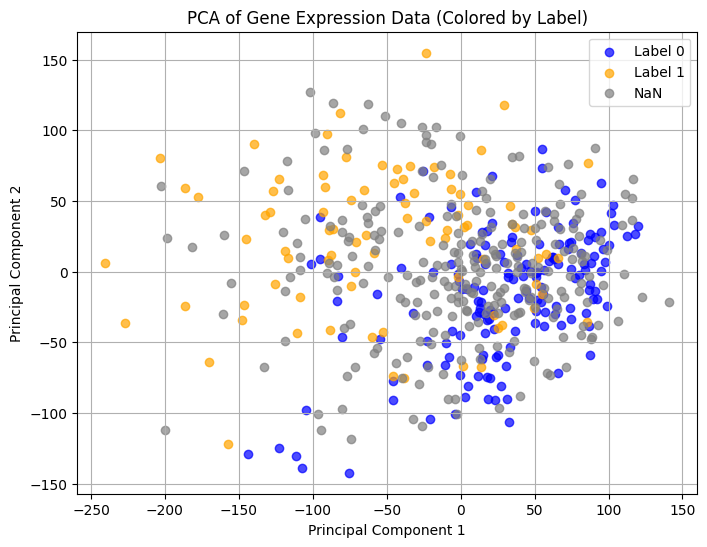

In [14]:
sorted_df_patient_info = df_patient_info.sort_index()
sorted_df_patient_info.head()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_patient_info.sort_index()

sorted_df_patient_info = df_patient_info.sort_index()
sorted_df_patient_info.head()

# Combine datasets column-wise
combined_data = pd.concat([df_fpkm, intensities_raw_T], axis=1)

# Separate the label column
labels = sorted_df_patient_info['FactorValue..high.risk.']

# Standardize the data (excluding the label column)
combined_data.columns = combined_data.columns.astype(str)
standardized_data = StandardScaler().fit_transform(combined_data)

# Perform PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(standardized_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'], index=combined_data.index)

# Plot PCA results, coloring by Label
plt.figure(figsize=(8, 6))

# Define groups (0, 1, NaN) and their corresponding colors
groups = {0: 'blue', 1: 'orange', np.nan: 'gray'}

for label, color in groups.items():
    if pd.isnull(label):  # Handle NaN group
        mask = labels.isnull()
        label_name = 'NaN'
    else:  # Handle 0 and 1 groups
        mask = labels == label
        label_name = f"Label {int(label)}"
    plt.scatter(
        pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'],
        label=label_name, color=color, alpha=0.7
    )

plt.title("PCA of Gene Expression Data (Colored by Label)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

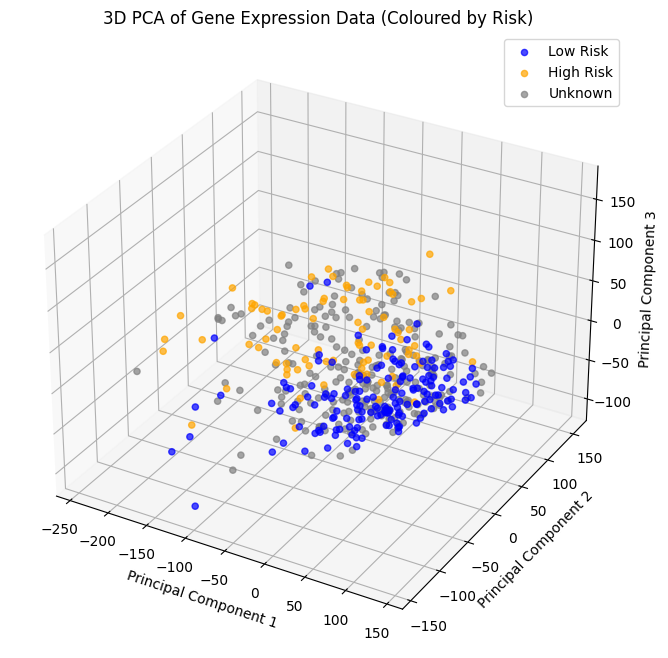

In [15]:
# Perform PCA (3 components for 3D visualization)
pca = PCA(n_components=3)
pca_results = pca.fit_transform(standardized_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'], index=combined_data.index)

# Plot 3D PCA, coloring by Label
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define groups (0, 1, NaN) and their corresponding colors
groups = {0: 'blue', 1: 'orange', np.nan: 'gray'}
labels_dict = {0: 'Low Risk', 1: 'High Risk', np.nan: 'Unknown'}

for label, color in groups.items():
    if pd.isnull(label):  # Handle NaN group
        mask = labels.isnull()
        label_name = labels_dict[label]  # Replace with descriptive label for NaN
    else:  # Handle 0 and 1 groups
        mask = labels == label
        label_name = labels_dict[label]  # Use descriptive label for 0 and 1
    
    # Scatter plot in 3D with color based on group
    ax.scatter(
        pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], pca_df.loc[mask, 'PC3'],
        label=label_name, color=color, alpha=0.7
    )

# Set labels for axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set plot title
ax.set_title("3D PCA of Gene Expression Data (Coloured by Risk)")

# Display legend
ax.legend()

# Show the plot
plt.show()

In [16]:
#Autoencoder to reduce to 50 features
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras import regularizers

# Define the autoencoder
def autoencoded(selected):
    input_dim = selected.shape[1] #number of input rows
    encoding_dim = 50  #reduce dimensions to 50
    input_layer = Input(shape=(input_dim,)) #number of features in the input data
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(1e-4))(input_layer)
    encoded = BatchNormalization()(encoded)
    #reduces number of features to 50 and uses Relu activation and L1 regularisation
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    #output layer of autoencoder which reconstructs the original input data

    autoencoder = Model(input_layer, decoded) #autoencoder model to train
    encoder = Model(input_layer, encoded)  #extract encoder for dimensionality reduction

    #train autencoder
    autoencoder.compile(optimizer='adam', loss='mse')
    #adam optimiser optimises the learning rate during training
    
    #trained based on mean squared error
    autoencoder.fit(selected, selected, epochs=50, batch_size=20, validation_split=0.2, verbose = 0)

    #get reduced features
    autoencoded = encoder.predict(selected)
    
    #
    encoded_df = pd.DataFrame(autoencoded, columns=[f"Encoded_Feature_{i+1}" for i in range(autoencoded.shape[1])], index = selected.index)
    
    return encoded_df, encoder, autoencoded

In [17]:
#convert categorical variables to numeric
def preprocessing (patient_df, fpkm, intensity):
    #convert sex to 0,1
    label_encoder = LabelEncoder()
    patient_df.loc[:, 'FactorValue..Sex.'] = label_encoder.fit_transform(patient_df['FactorValue..Sex.'])

    #standardise age to have mean 0 and variance 1
    scaler = StandardScaler()
    patient_df.loc[:, 'FactorValue..age.at.diagnosis.'] = scaler.fit_transform(patient_df[['FactorValue..age.at.diagnosis.']])
    
    #merge fpkm and intensities data
    patient_df = patient_df.drop(fpkm_columns, axis = 1)
    patient_df = patient_df.drop(intensity_columns, axis = 1)
    data = patient_df.merge(fpkm, left_on='ID', right_index=True)
    data_full = data.merge(intensity, left_on='ID', right_index=True)
    
    return data_full

In [18]:
#Best Hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 150, 'learning_rate': 0.0001, 'neurons': 32}
#Best Accuracy: 0.8504447459671342

#build model
def build_model(neurons=32, learning_rate = 0.001, dropout_rate = 0.2):
    
    model = Sequential([
    Dense(neurons, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid') #sigmoid activation for binary outcome
    ])
    
    model.build(input_shape=(None,102,)) #input number of features
    
    #set learning rate
    optim = optimizers.Adam(learning_rate = learning_rate)
    
    #define model (binary outcome)
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model
       
def train_model(model, x_train, x_test, y_train, y_test):
    
    print(model.summary())
    
    #convert data to floats for tensorflow
    x_train = np.array(x_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    x_test = np.array(x_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    #train model
    log = model.fit(x_train, y_train,
                        batch_size=32,
                        validation_data=(x_test, y_test),
                        epochs=100,
                        verbose=False)
    
    # plot history of the loss over time
    plt.plot(log.history['loss'], label='Training Loss')
    plt.plot(log.history['val_loss'], label='Test Loss')
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')

    # also display final accuracy in corner of plot
    final_loss = log.history['val_loss'][-1]
    final_train_accuracy = log.history['binary_accuracy'][-1] #binary accuracy from model metrics
    final_test_accuracy = log.history['val_binary_accuracy'][-1] #binary accuracy from model metrics
    plt.annotate(f'Final train acc: {final_train_accuracy:.3}', (0.2, 0.9), xycoords='axes fraction')
    plt.annotate(f'Final validation acc: {final_test_accuracy:.3}', (0.2, 0.8), xycoords='axes fraction')
    
    plt.show()
    
    #evaluate the model
    y_pred = model.predict(x_test) #predict y based on test data
    y_pred_binary = (y_pred > 0.5).astype(int)  #convert probabilities to binary predictions
    accuracy = accuracy_score(y_test, y_pred_binary) #compare predictions to true values
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    # Display confusion matrix
    print(cm)
    
    #report = sklearn.metrics.classification_report(y_test_k, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')
    report = classification_report(y_test_k, y_pred_binary, output_dict=True)
    
    # Convert to a DataFrame
    report_df = pd.DataFrame(report).iloc[:-1, :-1]  # Exclude 'accuracy' row and 'support' column

    # Plot as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(report_df, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Classification Report Heatmap")
    plt.ylabel("Classes")
    plt.xlabel("Metrics")
    plt.show()
    
    return accuracy, y_pred, cm

In [19]:
fpkm_columns = df_fpkm.columns
fpkm_columns
intensity_columns = intensities_raw_T.columns
intensity_columns

Index([41426, 21664, 43382, 39007, 41425, 35653, 28919, 43380, 41190, 22779,
       ...
       43592, 39351, 40212, 43593,   737, 33927, 33952, 34832, 24669, 39350],
      dtype='int64', name='Reporter.Identifier', length=9848)

Starting fold 1


/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025-04-16 17:46:26.422479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-16 17:46:26.422513: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-16 17:46:26.422552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runn

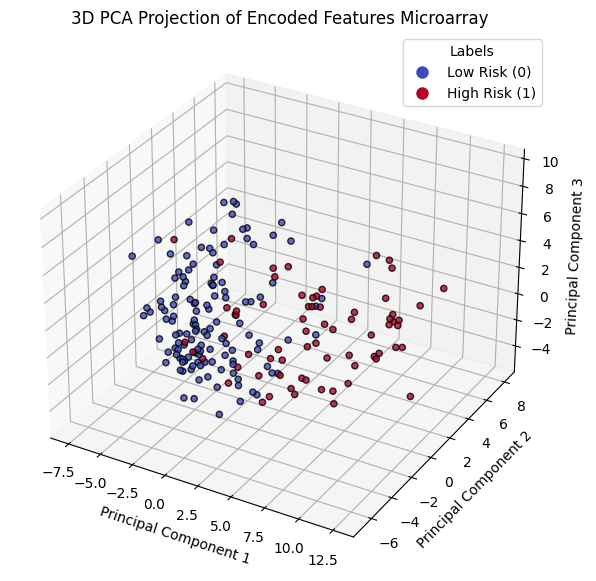

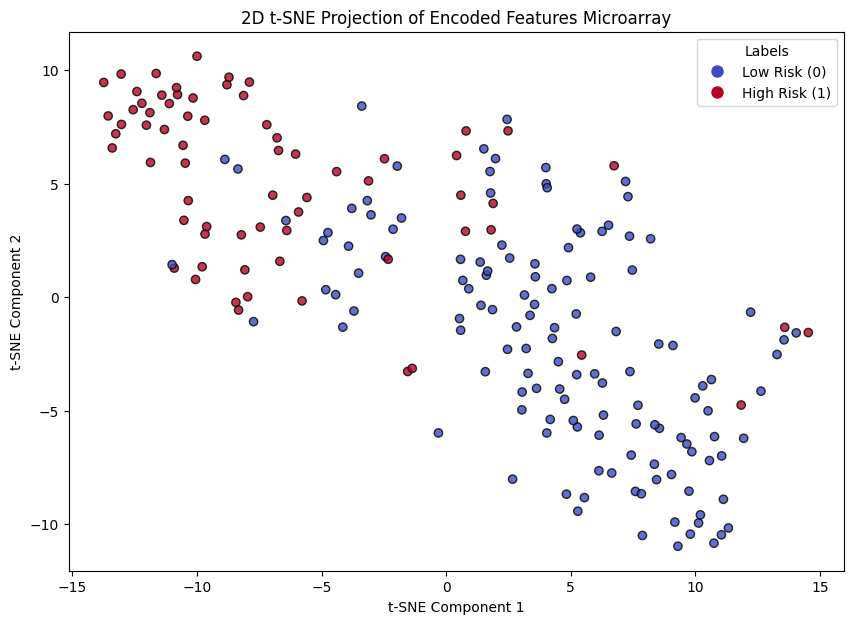

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                3296      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
None


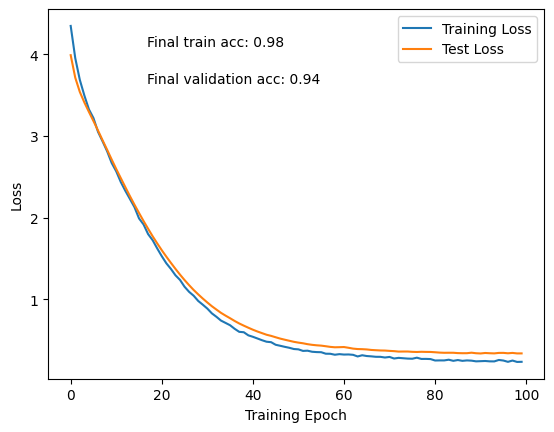

[[31  2]
 [ 1 16]]


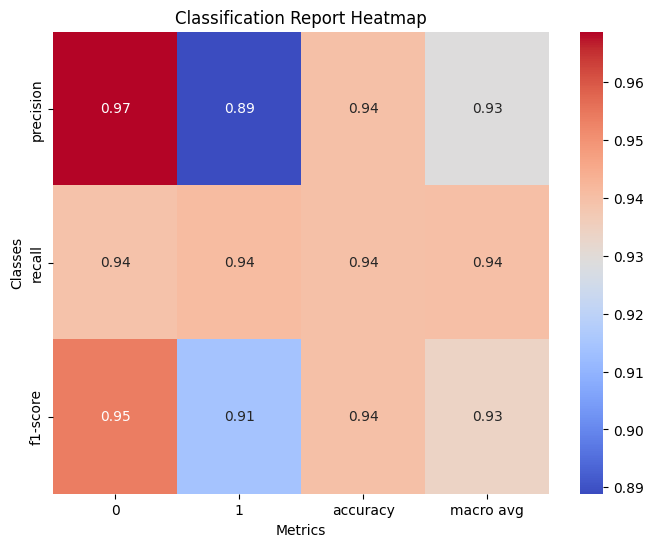

Starting fold 2


/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


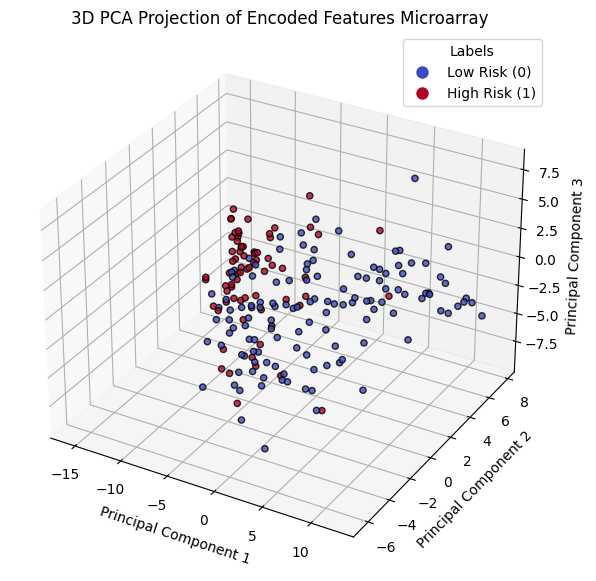

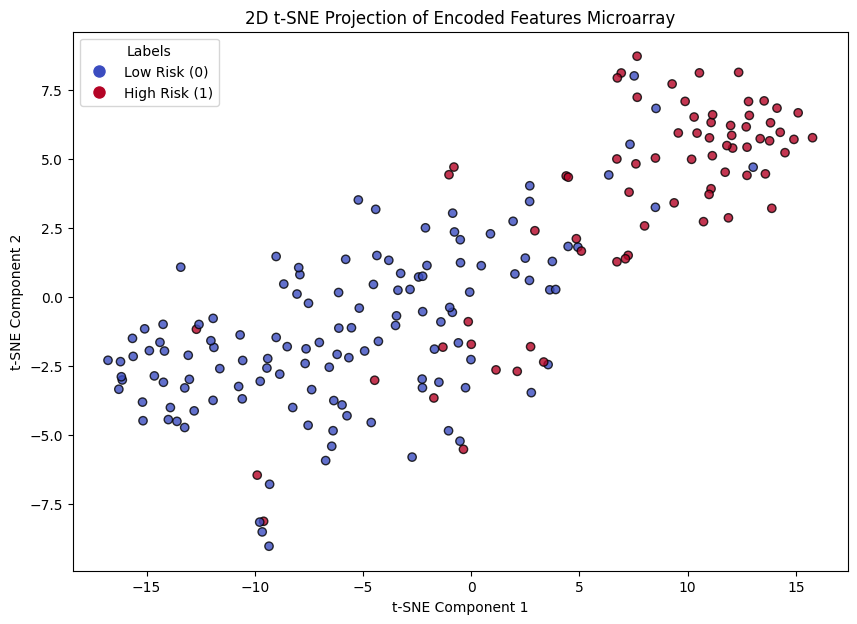

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                3296      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
None


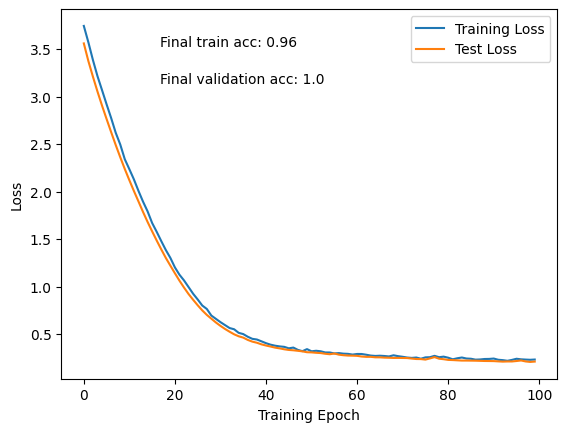

[[35  0]
 [ 0 15]]


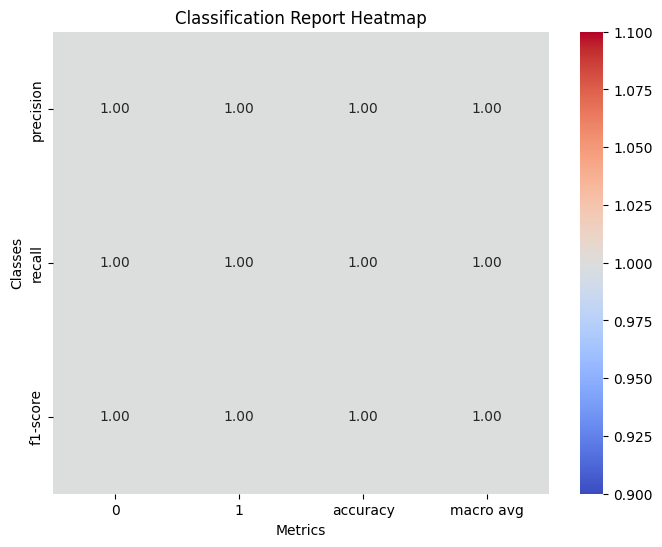

Starting fold 3


/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


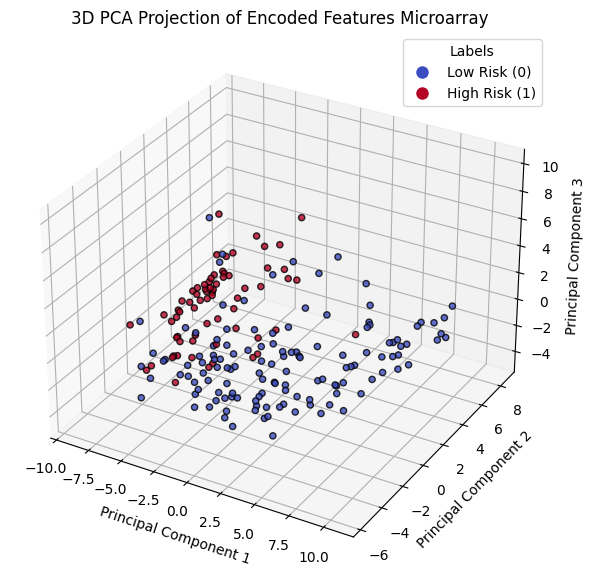

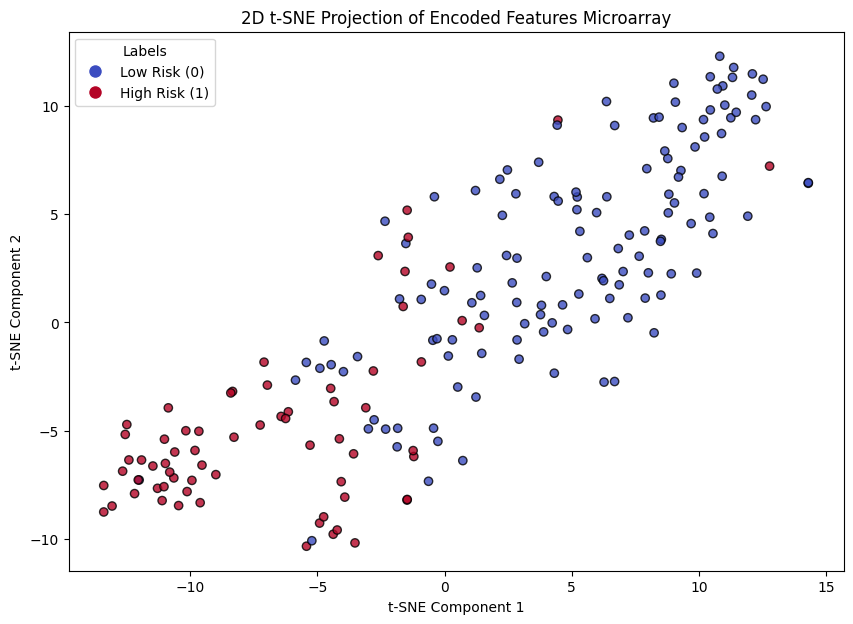

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                3296      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
None


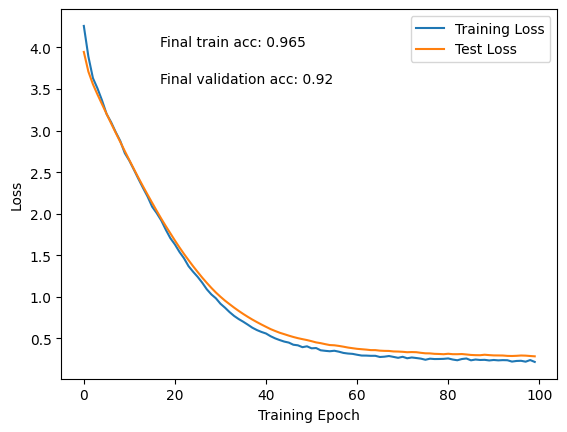

[[31  1]
 [ 3 15]]


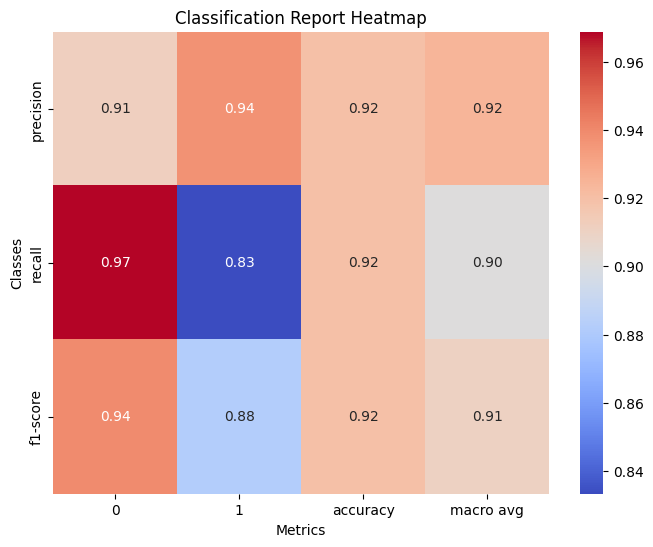

Starting fold 4


/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


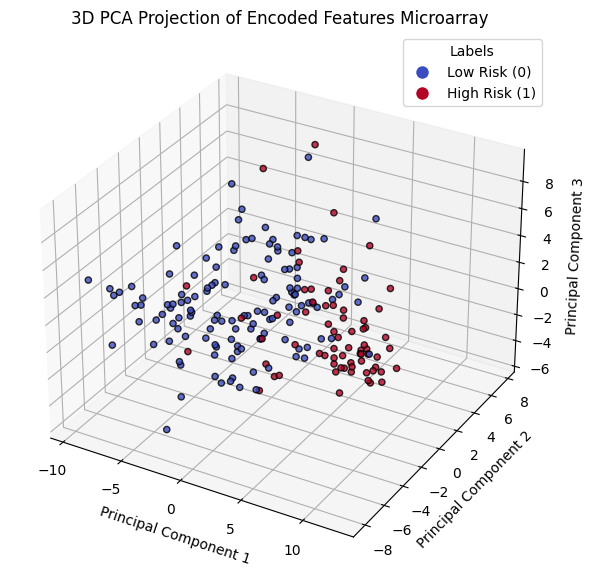

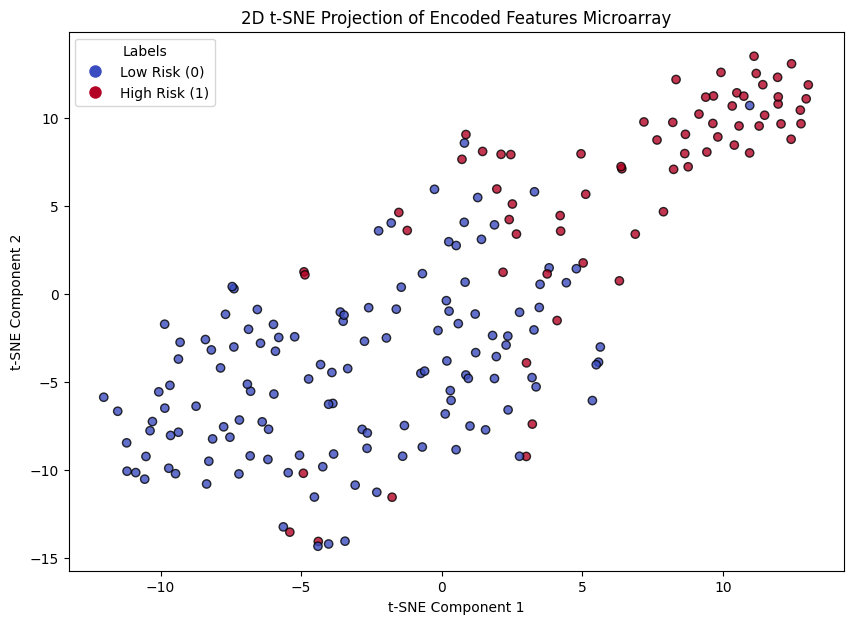

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 32)                3296      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
None


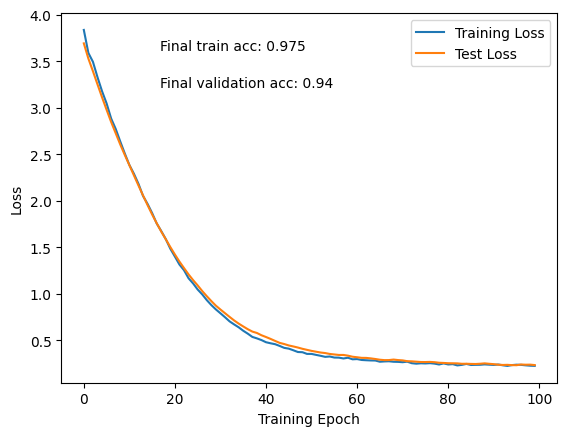

[[31  2]
 [ 1 16]]


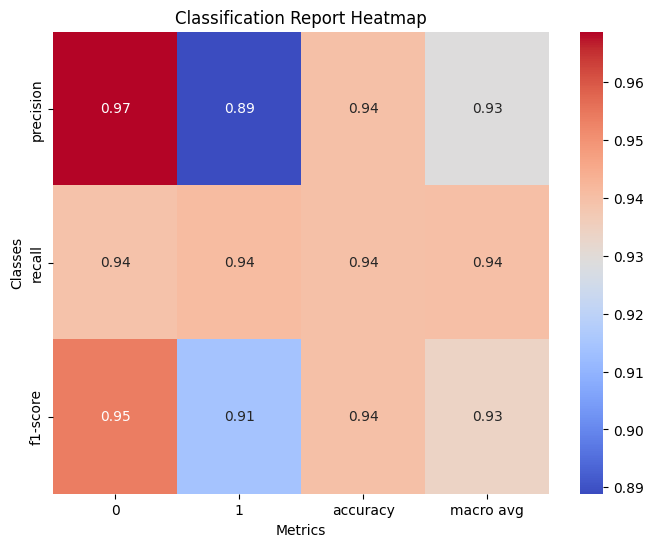

Starting fold 5


/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib64/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


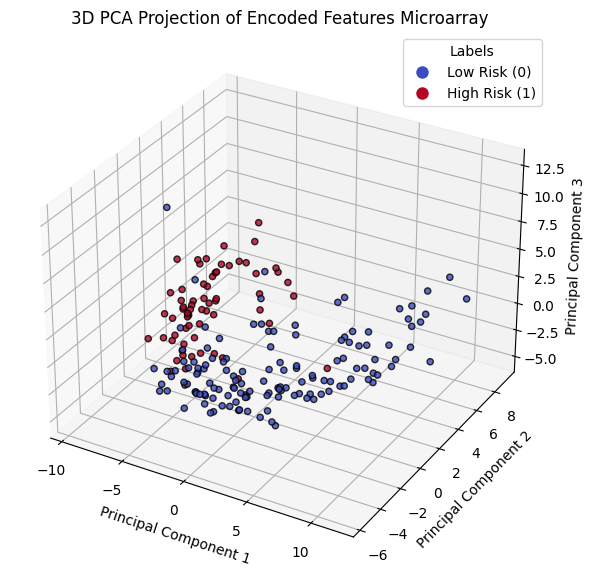

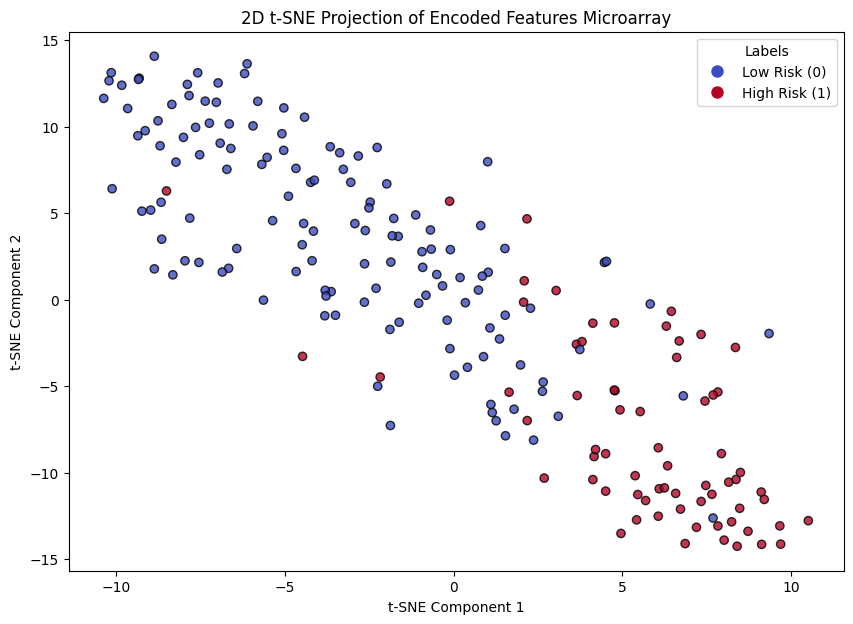

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                3296      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
None


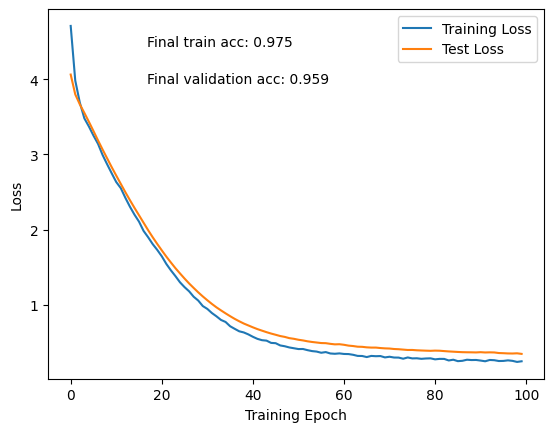

[[29  1]
 [ 1 18]]


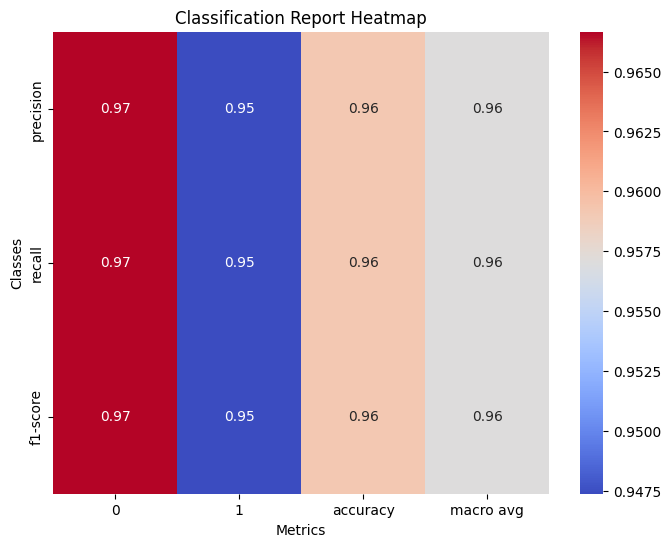

Average test accuracy across 5 folds: 0.9518367346938774
Best model was from fold {2}


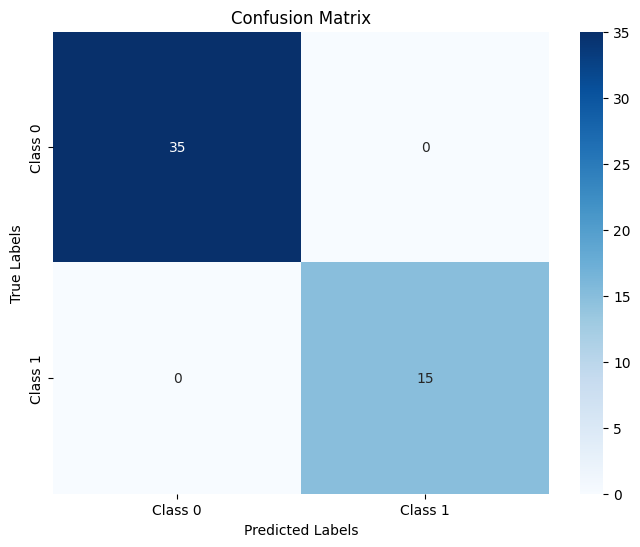

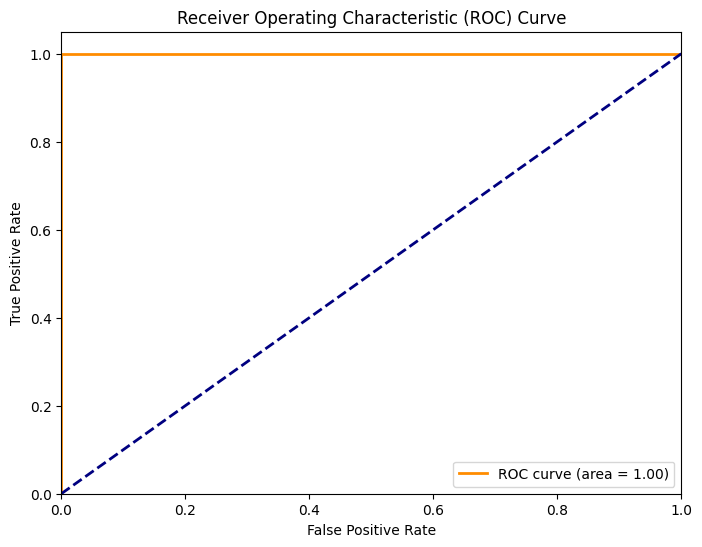

In [20]:
#Using K-fold validation
# Define the KFold
X = X_final
y = y_train
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store the evaluation metrics for each fold
fold_scores = []
fold_no = 1
best_fold = None
best_accuracy = 0
top_y_true = []
top_y_prob = []
top_cm = []

for train_index, test_index in kf.split(X,y):
    print(f"Starting fold {fold_no}")
    # Split the data into training and test sets for this fold
    X_train_k, X_test_k = X.iloc[train_index], X.iloc[test_index]
    y_train_k, y_test_k = y.iloc[train_index], y.iloc[test_index]
    
    #preprocess inside loop
    
    #index fpkm data from training data
    fpkm_train = X_train_k[fpkm_columns]
    fpkm_test = X_test_k[fpkm_columns]

    #log transform fpkm train and validation separately
    fpkm_log_train = np.log2(fpkm_train +1)
    fpkm_log_test = np.log2(fpkm_test +1)
    
    #scale fpkm train and validation separately
    scaler = StandardScaler() #scaler for mean 0 and variance 1
    fpkm_scaled_train = scaler.fit_transform(fpkm_log_train) #scale train
    fpkm_scaled_test = scaler.transform(fpkm_log_test) #scale test with same function
    fpkm_scaled_train_df = pd.DataFrame(fpkm_scaled_train, columns=fpkm_log_train.columns, index=fpkm_log_train.index) #convert to df
    fpkm_scaled_test_df = pd.DataFrame(fpkm_scaled_test, columns=fpkm_log_test.columns, index=fpkm_log_test.index) #convert to df

    #filter intensity data to keep only common IDs
    intensity_train = X_train_k[intensity_columns]
    intensity_test = X_test_k[intensity_columns]

    #log transform intensities separately
    intensity_log_train = np.log2(intensity_train +1)
    intensity_log_test = np.log2(intensity_test +1)
    
    #scale fpkm separately
    scaler = StandardScaler()
    intensity_scaled_train = scaler.fit_transform(intensity_log_train)  # Fit and transform on TRAINING data
    intensity_scaled_test = scaler.transform(intensity_log_test)
    intensity_scaled_train_df = pd.DataFrame(intensity_scaled_train, columns=intensity_log_train.columns, index=intensity_log_train.index)
    intensity_scaled_test_df = pd.DataFrame(intensity_scaled_test, columns=intensity_log_test.columns, index=intensity_log_test.index)
    
    #feature reduction of training data to 500 features
    fpkm_train_selected = feature_reduction(fpkm_scaled_train_df, y_train_k)
    intensity_train_selected = feature_reduction(intensity_scaled_train_df, y_train_k)
    
    #apply feature reduction to training data
    fpkm_selected = fpkm_train_selected.columns
    intensity_selected = intensity_train_selected.columns
    fpkm_test_selected = fpkm_scaled_test_df[fpkm_selected]
    intensity_test_selected = intensity_scaled_test_df[intensity_selected]
    
    #autoencoder for feature reduction to 50 features train data
    reduced_train_fpkm, fpkm_encoder, autoencoded_fpkm = autoencoded(fpkm_train_selected)
    reduced_train_intensity, intensity_encoder, autoencoded_microarray = autoencoded(intensity_train_selected)
    
        # Example: Replace these with your actual encoded data
    # Assume `autoencoded_fpkm` and `autoencoded_microarray` are your PCA inputs
    # And `labels_fpkm` and `labels_microarray` contain 0/1 labels

    # Combine both datasets for PCA
    combined_data = np.vstack([autoencoded_fpkm, autoencoded_microarray])
    labels_y = np.hstack([y_train_k])  # 0s and 1s

    # Perform PCA (reduce to 3D)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(autoencoded_microarray)

    # 3D Scatter Plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with colors
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                         c=labels_y, cmap='coolwarm', edgecolors='k', alpha=0.8)

    # Labels and titles
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title("3D PCA Projection of Encoded Features Microarray")

    # Add legend
    legend_labels = {0: "Low Risk (0)", 1: "High Risk (1)"}
    scatter_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in legend_labels.keys()]
    ax.legend(scatter_legend, legend_labels.values(), title="Labels")

    plt.show()
    
        # Perform t-SNE (reduce to 3D)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    tsne_result = tsne.fit_transform(autoencoded_microarray)

    # 3D Scatter Plot
    fig, ax = plt.subplots(figsize=(10, 7))
    #ax = fig.add_subplot(111, projection='2d')

    # Scatter plot with colors
    scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], #tsne_result[:, 2],
                         c=labels_y, cmap='coolwarm', edgecolors='k', alpha=0.8)

    # Labels and titles
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    #ax.set_zlabel("t-SNE Component 3")
    ax.set_title("2D t-SNE Projection of Encoded Features Microarray")

    # Add legend
    legend_labels = {0: "Low Risk (0)", 1: "High Risk (1)"}
    scatter_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in legend_labels.keys()]
    ax.legend(scatter_legend, legend_labels.values(), title="Labels")
    
    plt.show()
    
    #use same transformation for test data                                              
    reduced_test_fpkm_features = fpkm_encoder.predict(fpkm_test_selected)
    reduced_test_intensity_features = intensity_encoder.predict(intensity_test_selected)
    reduced_test_fpkm = pd.DataFrame(reduced_test_fpkm_features, columns=[f"Encoded_Feature_{i+1}" for i in range(reduced_test_fpkm_features.shape[1])], index = fpkm_test_selected.index)
    reduced_test_intensity = pd.DataFrame(reduced_test_intensity_features, columns=[f"Encoded_Feature_{i+1}" for i in range(reduced_test_intensity_features.shape[1])], index = intensity_test_selected.index)
    
    #selected_features_fpkm = omp(fpkm_train_selected, y_train_k)
    #selected_features_intensity = omp(intensity_train_selected, y_train_k)
    
    #reduced_train_fpkm = fpkm_train_selected.iloc[:, selected_features_fpkm]
    #reduced_train_intensity = intensity_train_selected.iloc[:, selected_features_intensity]
    #reduced_test_fpkm = fpkm_test_selected.iloc[:, selected_features_fpkm]
    #reduced_test_intensity = fpkm_test_selected.iloc[:, selected_features_intensity]
    
    #cleaning up and merging data
    train_data_full = preprocessing(X_train_k, reduced_train_fpkm, reduced_train_intensity)
    test_data_full = preprocessing(X_test_k, reduced_test_fpkm, reduced_test_intensity)
    
    #build model
    model = build_model()
    
    accuracy, y_pred, cm = train_model(model, train_data_full, test_data_full, y_train_k, y_test_k)
    
    #calculate accuracy for this fold
    fold_scores.append(accuracy)
    
    # Save the best-performing model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = {fold_no}
        model.save("best_model.h5")
        top_fpkm_features = fpkm_train_selected.columns
        top_intensity_features = intensity_train_selected.columns
        top_fpkm_encoder = fpkm_encoder
        top_intensity_encoder = intensity_encoder
        top_y_true = y_test_k
        top_y_prob = y_pred
        top_cm = cm
    
    fold_no += 1

# Calculate the average accuracy across all folds
average_score = np.mean(fold_scores)
print(f"Average test accuracy across {k} folds: {average_score}")
print(f"Best model was from fold {best_fold}")

#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(top_y_true, top_y_prob)
roc_auc = auc(fpr, tpr)

#Plot top confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(top_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [21]:
labels_y

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [22]:
print("Selected features:", selected_features_fpkm)

NameError: name 'selected_features_fpkm' is not defined

In [ ]:
#wrap model so it behaves like scikitlearn classifier
model = KerasClassifier(build_fn=build_model, verbose=0)

#parameters to test
param_grid = {
'neurons': [4, 8, 16, 32],
'learning_rate': [0.0001, 0.001, 0.01, 0.1],
'batch_size': [16, 32, 64],
'epochs': [100, 150, 200],
'dropout_rate': [0.2, 0.3, 0.5]
}
    
#create grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv = 3, verbose=0)

#convert data to arrays
train_data_full = np.array(train_data_full, dtype=np.float32)
y_train_k = np.array(y_train_k, dtype=np.float32)
  
#fit grid search
grid_search.fit(train_data_full, y_train_k)

#print best hyperparameters and best accuracy score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_}")

In [23]:
#preprocess test data

#construct predictor variable dataframe for model
Y_before = df_patient_info_test.drop(["FactorValue..death.from.disease.","FactorValue..high.risk.","FactorValue..progression.","FactorValue..inss.stage."], axis = 1).sort_index()
merged_gene = df_fpkm.merge(intensities_raw_T, left_index=True, right_index=True, how='inner')
gene_train = merged_gene.loc[Y_before.index]
#df_intensity_train = intensities_raw.loc[intensities_raw.index.isin(X)]
Y_final = gene_train.merge(Y_before, left_index=True, right_index=True, how='inner')

Y_final = Y_final.reindex(y_test.index)
Y_final.head()

#index fpkm data from test data
fpkm_y = Y_final[fpkm_columns]

#log transform fpkm test
fpkm_log_y = np.log2(fpkm_y +1)
    
#scale fpkm test
scaler = StandardScaler() #scaler for mean 0 and variance 1
fpkm_scaled_y = scaler.fit_transform(fpkm_log_y) #scale train
fpkm_scaled_y_df = pd.DataFrame(fpkm_scaled_y, columns=fpkm_log_y.columns, index=fpkm_log_y.index) #convert to df

#index intensity data from test data
intensity_y = Y_final[intensity_columns]

#log transform intensity test
intensity_log_y = np.log2(intensity_y +1)
    
#scale intensity test
scaler = StandardScaler() #scaler for mean 0 and variance 1
intensity_scaled_y = scaler.fit_transform(intensity_log_y) #scale train
intensity_scaled_y_df = pd.DataFrame(intensity_scaled_y, columns=intensity_log_y.columns, index=intensity_log_y.index) #convert to df

#select features from best model
fpkm_y_select = fpkm_scaled_y_df[top_fpkm_features]
intensity_y_select = intensity_scaled_y_df[top_intensity_features]

#autoencode to reduce features to 50
fpkm_y_reduced = autoencoded(fpkm_y_select)
intensity_y_reduced = autoencoded(intensity_y_select)

#autoencode to reduce features to 50
reduced_y_fpkm_features = top_fpkm_encoder.predict(fpkm_y_select)
reduced_y_intensity_features = top_intensity_encoder.predict(intensity_y_select)
fpkm_y_reduced = pd.DataFrame(reduced_y_fpkm_features, columns=[f"Encoded_Feature_{i+1}" for i in range(reduced_y_fpkm_features.shape[1])], index = fpkm_y_select.index)
intensity_y_reduced = pd.DataFrame(reduced_y_intensity_features, columns=[f"Encoded_Feature_{i+1}" for i in range(reduced_y_intensity_features.shape[1])], index = intensity_y_select.index)

#merge datasets back together
Y_final_final = preprocessing(Y_final, fpkm_y_reduced, intensity_y_reduced)

Y_final_final.head()

,FactorValue..Sex.,FactorValue..age.at.diagnosis.,Encoded_Feature_1_x,Encoded_Feature_2_x,Encoded_Feature_3_x,Encoded_Feature_4_x,Encoded_Feature_5_x,Encoded_Feature_6_x,Encoded_Feature_7_x,Encoded_Feature_8_x,...,Encoded_Feature_41_y,Encoded_Feature_42_y,Encoded_Feature_43_y,Encoded_Feature_44_y,Encoded_Feature_45_y,Encoded_Feature_46_y,Encoded_Feature_47_y,Encoded_Feature_48_y,Encoded_Feature_49_y,Encoded_Feature_50_y
ID,,,,,,,,,,,,,,,,,,,,,
NB498,0,-0.247735,-0.952107,0.055451,1.501184,-1.066646,-0.942099,0.408777,-1.190939,-0.970062,...,-1.120779,-0.664013,-1.134270,0.913270,1.069876,-0.901875,-0.568230,-0.702445,-1.117568,0.489286
NB496,1,-0.593813,-0.301790,-0.962714,-1.066735,-1.066646,-0.942099,-1.041657,-1.132426,-0.970062,...,-0.662030,-0.552138,1.046091,-0.170672,1.089237,0.555410,-0.044668,0.089671,0.862315,1.106397
NB494,1,-0.659898,-0.952107,-0.962714,1.588009,-1.066646,-0.942099,0.600126,-1.190939,-0.970062,...,1.116226,-0.664013,-0.902434,1.750879,-0.743367,-0.901875,-0.568230,-0.702445,-0.302794,-0.602627
NB492,1,0.114863,-0.093953,1.931405,-1.155285,-0.894143,0.682182,-1.041657,0.491418,1.959873,...,-1.120779,-0.174279,-1.134270,-0.362591,0.785580,-0.901875,-0.507431,-0.283875,-1.117568,4.195561
NB490,0,0.820930,0.967274,3.094082,-1.155285,0.602782,1.090916,-1.041657,-1.190939,1.911063,...,-1.120779,3.827245,-1.134270,2.895934,-0.539626,-0.901875,-0.310470,4.222553,-1.117568,4.854713


In [24]:
from tensorflow.keras.models import load_model

# load the trained Keras model from the .h5 file
final_model = load_model('best_model.h5')

# convert df to array for prediction
Y_final_final_array = np.array(Y_final_final, dtype=np.float32)

# make prediction
predictions = final_model.predict(Y_final_final_array)

# convert predictions to binary outcomes (0 or 1) using 0.5 as a threshold
binary_predictions = (predictions > 0.5).astype(int)

# match the binary predictions back to patient IDs in a dataframe
predictions_df = pd.DataFrame(binary_predictions, index=Y_final_final.index, columns=['FactorValue..high.risk.'])

print(predictions_df)

       FactorValue..high.risk.
ID                            
NB498                        0
NB496                        0
NB494                        0
NB492                        1
NB490                        1
...                        ...
NB010                        1
NB008                        1
NB006                        0
NB004                        1
NB002                        1

[249 rows x 1 columns]


In [25]:
# Search for values 1 in the 'Predictions' column
filtered_df = predictions_df[predictions_df['FactorValue..high.risk.'] == 1]

# Display the result
print(filtered_df)
filtered_df.shape

       FactorValue..high.risk.
ID                            
NB492                        1
NB490                        1
NB486                        1
NB484                        1
NB480                        1
...                        ...
NB074                        1
NB010                        1
NB008                        1
NB004                        1
NB002                        1

[92 rows x 1 columns]


(92, 1)